# CATE estimation with synthetic dataset
Here, we explore the effectiveness of different scoring metrics in capturing the error between the estimated and true causal effects in small synthetic datasets.  

## Background
Often, different units are suceptible to a treatment to different degrees. Our goal is to use our toolbox to estimate these heterogenous treatment effects and assess how well the toolbox performs
In other words, how well does a score reflect the mismatch between the estimated and true causal effect?  
We divide our approach in different parts. First, we'll generate some synthetic data for which we know the relationship between variables, as well as the treatment effect. 
We'll consider two scenarios, with and without confounding variables. Next, we'll use AutoCausality for hyperparameter tuning and model selection of a zoo of causal estimators. We'll do this for different scoring methods.
Lastly, we'll plot the returned scores against the misestimation error between predicted and true treatment effect. 
Below, we import the relevant modules and define a few helper functions (TODO outsource the latter to autocausality, once approved)

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..
try:
    import graphviz
except ModuleNotFoundError as e:
    import pip
    pip.main(["install","graphviz"])
    import graphviz

from typing import Union

root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from sklearn.model_selection import train_test_split
from auto_causality import AutoCausality
from auto_causality.data_utils import preprocess_dataset


## Simulation 1: CATE without confounders
We will begin with a simple synthetic dataset, in which the outcome is influenced by the treatment and a set of covariates, which are independent of the treatment:

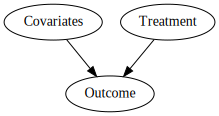

In [2]:
dot = graphviz.Digraph("causal-graph",comment="A simple causal graph",filename="rct_cate_graph.gv")
dot.node("X",label="Covariates")
dot.node("T",label="Treatment")
dot.node("Y",label="Outcome")
dot.edge("X","Y")
dot.edge("T","Y")
dot.edge_attr.update(arrowsize="1")
dot

### 1.1 Dataset generation

Let $X^{Nxd}$ be the matrix of $N$ observations and $d$ covariates, $T^{nx1}$ the vector of treatment assignments and $Y^{nx1}$ the vector of outcomes. 
We make the following assumptions:  
- binary treatments
- fully random propensity to treat (unconfoundedness)
- five continuous, normally distributed covariates
- no interaction between treatment effects and covariates 
- independence of the covariates, i.e. $\Sigma = \sigma^2I$
- no additive noise in the outcomes, i.e. $\epsilon=0$

  
Then, the data is generated according to the following equations:
\begin{align*}
X_i \sim \mathcal{N}(0,\Sigma) \\\\
T_i \sim Bernoulli(0.5) \\\\
Y_i = \tau(X_i) T_i + \mu_0(X_i) + \epsilon
\end{align*}
where $i$ indexes individual units, $\tau$ describes the following true treatment effect, which depends linearly on all covariates:
\begin{equation*}
\tau(X_i) = X_ib^T + e
\end{equation*}
where $b$ is a 1xd vector of $b_i \sim U(0.4,0.7)$ weights for each covariate and $e \sim \mathcal{N}(0,0.05)$ gaussian noise.  
... and  $\mu_0(x)$ describes the following transformation of the covariates (to keep things interesting):
\begin{equation*}
\mu_0(X_i) = X_{i,1} \otimes X_{i,2} + X_{i,3} + X_{i,4} \otimes X_{i,5} 
\end{equation*}




In [3]:
def generate_psdmat(n_dims: int = 10) -> np.ndarray:
    """generates a symmetric, positive semidefinite matrix

    Args:
        n_dims (int, optional): number of dimensions. Defaults to 10.

    Returns:
        np.ndarray: psd matrix
    """
    A = np.random.rand(n_dims, n_dims)
    A = A@A.T
    
    return A


def mu_zero(X:np.ndarray) -> np.ndarray:
    """hard-coded transformation of covariates, including interaction terms

    Args:
        X (np.ndarray): matrix of n observations and d covariates

    Returns:
        np.ndarray: transformed matrix
    """
    return X[:,0] * X[:,1] + X[:,2] + X[:,3] * X[:,4]

def generate_cate_data(
    n_samples: int = 100,
    n_covariates: int = 5,
    covariance: Union[str, np.ndarray] = "isotropic",
    confounding: bool = False,
    random_propensity: bool = True,
    noisy_outcomes: bool = False,

) -> pd.DataFrame:
    """generates synthetic dataset with random heterogenous treatment effects

    Args:
        n_samples (int, optional): number of independent samples. Defaults to 100.
        n_covariates (int, optional): number of covariates. Defaults to 5.
        covariance (Union[str, np.ndarray], optional): covariance matrix of covariates. can be "isotropic", "anisotropic" or user-supplied. Defaults to "isotropic".
        confounding (bool, optional): whether or not values of covariates affect treatment effect. Defaults to False.        
        noisy_outcomes (bool, optional): additive noise in the outcomes. Defaults to False.

    Returns:
        pd.DataFrame: columns for covariates, treatment assignment, outcome and true treatment effect
    """

    if covariance == "isotropic":
        sigma = np.random.randn(1)
        covmat = np.eye(n_covariates)*sigma**2
    elif covariance == "anisotropic":
        covmat = generate_psdmat(n_covariates)

    X = np.random.multivariate_normal(mean=[0]*n_covariates,cov=covmat,size=n_samples)

    
    if confounding:
        T = 1/(1+np.exp(X[:,0]*X[:,1]+X[:,2]*3)) > np.random.rand(n_samples)
    else:
        T = np.random.binomial(n=1, p=0.5,size=n_samples)

    # heterogeneity in effect size:
    weights = np.random.uniform(low=0.4,high=0.7,size=n_covariates)
    e = np.random.randn(n_samples) * 0.01
    tau = X@weights.T + e


    err = np.random.randn(n_samples) *0.05 if noisy_outcomes else 0

    Y = tau*T + mu_zero(X) + err

    df = pd.DataFrame(np.array([*X.T,T,Y,tau]).T,columns=[f"X{i}" for i in range(1,n_covariates+1)]+["treatment","outcome","true_effect"])
    return df

## 1.2 Preprocessing
Now we apply AutoCausality's built-in preprocessing pipeline and construct train/val/test sets

In [4]:
data = generate_cate_data(n_samples=1000,confounding=False)
outcome = "outcome"
data_df, features_X, features_W = preprocess_dataset(data, treatment="treatment", targets=["outcome"])
# drop true effect:
features_X = [f for f in features_X if f != "true_effect"]
print(f"features_X: {features_X}")
print(f"features_W: {features_W}")
data_df.head(10)

features_X: ['X1', 'X2', 'X3', 'X4', 'X5']
features_W: ['random']


,treatment,outcome,X1,X2,X3,X4,X5,true_effect,random
0,0.0,-0.028902,-0.222111,-0.021085,-0.035625,-0.040263,-0.050667,-0.163924,1.0
1,0.0,-0.439717,-0.214064,-0.061309,-0.484248,-0.272611,-0.115207,-0.620563,1.0
2,0.0,0.139378,0.006898,-0.117973,0.140801,-0.077997,0.007815,0.006419,1.0
3,0.0,-0.007470,-0.058423,0.433180,0.080612,-0.278098,0.225727,0.284779,0.0
4,0.0,-0.140741,0.068472,0.148304,-0.126949,-0.158348,0.151226,0.043293,0.0
5,0.0,0.135202,0.047395,-0.081293,0.201541,-0.218774,0.285620,0.163943,1.0
6,0.0,0.033731,0.216293,-0.065084,0.065957,-0.237163,0.076528,0.043965,1.0
7,0.0,-0.182068,0.221773,-0.212452,-0.135168,-0.008958,-0.024146,-0.128540,1.0
8,0.0,0.064086,-0.012589,0.040626,0.070679,0.062950,-0.096611,0.032318,0.0
9,1.0,-0.004244,-0.239583,0.156619,-0.009420,0.009269,0.085953,0.041903,0.0


In [5]:
train_df, test_df = train_test_split(data_df, test_size=0.2)
test_df = test_df.reset_index(drop=True)

## 1.3 Model fitting
Now we're ready to find the best fitting model, given a user-specified metric. As we'd like to compare different metrics, we'll be doing this in a for-loop

In [6]:
metrics = ["r_scorer"] # ["norm_erupt", "qini", "r_scorer"]

# train_df, test_df = train_test_split(data_df, test_size=0.2)
test_df = test_df.reset_index(drop=True)

for i, metric in enumerate(metrics):

    ac = AutoCausality(
        metric=metric, verbose=1, components_verbose=1, components_time_budget=60,
    )

    ac.fit(
        train_df,
        treatment="treatment",
        outcome="outcome",
        common_causes=features_W,
        effect_modifiers=features_X,
    )
    scores = {}
    # compute relevant scores (skip newdummy)
    for est_name, scr in ac.scores.items():
        if "NewDummy" not in est_name:

            causal_estimate = scr["estimator"]

            scr["scores"]["test"] = ac.scorer.make_scores(
                causal_estimate,
                test_df,
                problem=ac.problem,
                metrics_to_report=ac.metrics_to_report,
            )
            # add cate:
            scr["scores"]["test"]["values"][
                "CATE_estimate"
            ] = causal_estimate.estimator.effect(test_df)
            # add ground truth for convenience
            scr["scores"]["test"]["values"]["CATE_groundtruth"] = test_df["true_effect"]
            scores[est_name] = scr["scores"]["test"]

    results = {
        "best_estimator": ac.best_estimator,
        "best_config": ac.best_config,
        "best_score": ac.best_score,
        "optimised_metric": metric,
        "scores_per_estimator": scores,
    }
    with open("synthetic_rct_cate_" + metric + ".pkl", "wb") as f:
        pickle.dump(results, f)



Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks


[flaml.tune.tune: 09-15 16:04:21] {335} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 09-15 16:04:21] {456} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}


Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.NewDummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest

[flaml.tune.tune: 09-15 16:04:33] {456} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.auto_causality.models.NewDummy'}}
[flaml.tune.tune: 09-15 16:04:45] {456} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 09-15 16:05:45] {456} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 09-15 16:08:46] {456} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}
[flaml.tune.tune: 09-15 16:10:47] {456} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 100, '

Exception: Optimization failed! Did you set large enough time_budget and components_budget?

## 1.4 Evaluation
How well did the different metrics quantify the mismatch between estimated and true treatment effects?

Text(0.5, 1.0, 'norm_erupt')

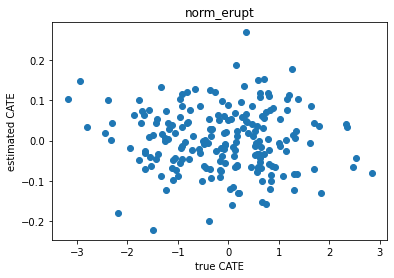

In [24]:
# plot true against estimated:
%matplotlib inline
plt.scatter(test_df["true_effect"],ac.scores[ac.best_estimator]["scores"]["test"]["values"]["CATE_estimate"])
plt.xlabel("true CATE")
plt.ylabel("estimated CATE")
plt.title(ac.metric)

now plot the score against the mse between estimated and true cate for each of the models in the scores dict

In [72]:
print(ac.scores.keys())

dict_keys(['backdoor.auto_causality.models.Dummy', 'backdoor.auto_causality.models.NewDummy', 'backdoor.auto_causality.models.TransformedOutcome', 'backdoor.econml.dml.CausalForestDML', 'backdoor.econml.dr.ForestDRLearner', 'backdoor.econml.metalearners.DomainAdaptationLearner', 'backdoor.econml.metalearners.SLearner'])


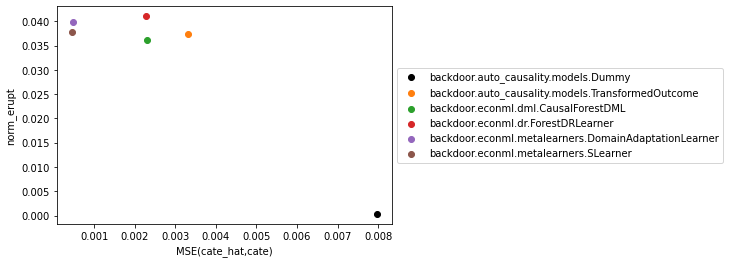

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])

true_cate = test_df["true_effect"]
for (est_name, scr), col in zip(ac.scores.items(),colors):
    if "NewDummy" in est_name:
        pass
    else:
        estimated_cate = scr["scores"]["test"]["values"]["CATE_estimate"]
        mse = np.mean((true_cate-estimated_cate)**2)
        plt.scatter(mse,scr["scores"]["test"]["norm_erupt"],color=col)
plt.xlabel("MSE(cate_hat,cate)")
plt.ylabel(ac.metric)
plt.legend([k for k in ac.scores.keys() if "NewDummy" not in k],loc='center left', bbox_to_anchor=(1, 0.5))